## Predicting the Expressions using CNN Model

## Part 1: CNN Trained on FER-2013 Image dataset

In [1]:
import cv2
from deepface import DeepFace
import numpy as np  

In [23]:
face_cascade = cv2.CascadeClassifier('C:\\Users\\Khizer Ahmed\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')

In [24]:
img = cv2.imread('labelme_sewqvmzqmdurewp.jpg')

In [25]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [26]:
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

In [27]:
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

In [28]:
cv2.imshow('img', img)
cv2.waitKey()

-1

In [2]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
# print("Tensorflow version:", tf.__version__)

import pandas as pd
import seaborn as sns
from sklearn import metrics

In [3]:
for expression in os.listdir(r"D:\MCM Practicum\FacialExpressionDataset\train\train"):`
    print(str(len(os.listdir(r"D:\MCM Practicum\FacialExpressionDataset\train\train\\" + expression))) + " " + expression + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


In [65]:
for expression in os.listdir(r"D:\MCM Practicum\FacialExpressionDataset\test\test"):

    print(str(len(os.listdir(r"D:\MCM Practicum\FacialExpressionDataset\test\test\\" + expression))) + " " + expression + " images")

958 angry images
111 disgust images
1024 fear images
1774 happy images
1233 neutral images
1247 sad images
831 surprise images


In [27]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip = True)

train_generator = datagen_train.flow_from_directory(r"D:\MCM Practicum\FacialExpressionDataset\train\train",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)


datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_validation.flow_from_directory(r"D:\MCM Practicum\FacialExpressionDataset\test\test",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [54]:
#Model Architecture 


# Initialising the CNN
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_64 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_46 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 24, 24, 128)     

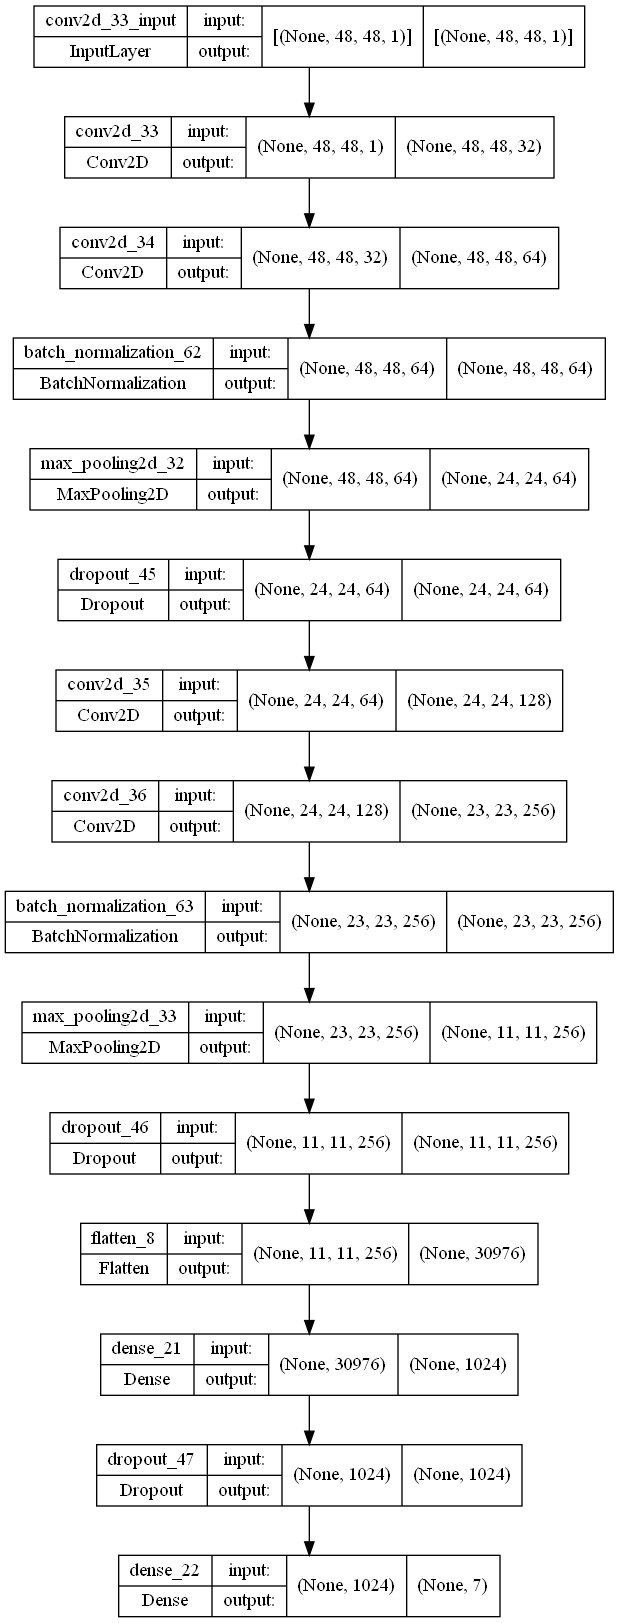

In [38]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

In [43]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
#Model Training and Building 

# %%time
epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=2, min_lr=0.00001, mode='auto')

early=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, early]
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [46]:
# # Don't run this ## To save the model

# model_json = model.to_json()
# model.save_weights('model_weights.h5')
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

In [45]:
#For loading the model run this. 

from tensorflow.keras.models import model_from_json

class FacialExpressionModel(object):    
    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]    
    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)   
            
        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()    
        
    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

In [46]:
## Defining OpenCV harcascade-classifier

facec = cv2.CascadeClassifier(R'C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')
model = FacialExpressionModel("CNN_model_final\model.json", "CNN_model_final\model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

In [6]:
## Creating a vedios LABELLED on CNN dataset.

data = pd.DataFrame()

In [7]:
data['Frame_No.'] = ''
data['Time_Stamp'] = ''
data['Emotion_Predicted'] = ''

In [8]:
## Checking the emotions for one of the video Video 41.mp4

# # folder = 'Vedios'
# for filename in os.listdir(folder):
# #     print(filename)
facec = cv2.CascadeClassifier(R'C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')
font = cv2.FONT_HERSHEY_SIMPLEX
cap = cv2.VideoCapture("Video 1.mp4")
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
frame_size = (frame_width,frame_height)
fps = 20
frame_no =1

output = cv2.VideoWriter(f'output_comp.mp4', cv2.VideoWriter_fourcc(*'XVID'), 20, frame_size)
while(cap.isOpened()):
    # vid_capture.read() methods returns a tuple, first element is a bool
    # and the second is frame
    
    
    ret, frame = cap.read()
    if ret == True:
        gray_fr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)        
        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]            
            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])
            cv2.putText(frame, pred, (x, y), font, 1, (255, 0, 0), 2)
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),4) 
            

    # Write the frame to the output files
        output.write(frame)
        
    #Writing the frame and its identified emotion
        data = data.append({'Frame_No.':frame_no,'Time_Stamp':cap.get(cv2.CAP_PROP_POS_MSEC),'Emotion_Predicted':pred},ignore_index= True)  
        
    else:
#             print("Stream disconnected")
        break
    frame_no += 1
data.to_csv('Vedios 1.csv')

cap.release()
output.release()

In [47]:
#Applying the model to all the vedios, for emotion recognition.

facec = cv2.CascadeClassifier(R'C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

folder = 'Vedios'
for filename in os.listdir(folder):
#     print(filename)
    data = pd.DataFrame()
    data['Frame_No.'] = ''
    data['Time_Stamp'] = ''
    data['Emotion_Predicted'] = ''
    cap = cv2.VideoCapture(f"{folder}/{filename}")
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    frame_size = (frame_width,frame_height)
    fps = 20
    frame_no =1

    output = cv2.VideoWriter(f'CNN_EmotionRecognised/{filename}', cv2.VideoWriter_fourcc(*'XVID'), 20, frame_size)
    while(cap.isOpened()):
    # vid_capture.read() methods returns a tuple, first element is a bool
    # and the second is frame
        ret, frame = cap.read()
        if ret == True:
            gray_fr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = facec.detectMultiScale(gray_fr, 1.3, 5)        
            for (x, y, w, h) in faces:
                fc = gray_fr[y:y+h, x:x+w]            
                roi = cv2.resize(fc, (48, 48))
                pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])
                cv2.putText(frame, pred, (x, y), font, 1, (255, 0, 0), 2)
                cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),4) 
    # Write the frame to the output files
            output.write(frame)
            data = data.append({'Frame_No.':frame_no,'Time_Stamp':cap.get(cv2.CAP_PROP_POS_MSEC),'Emotion_Predicted':pred},ignore_index= True)  

        else:
            print(f"{filename} Completed")
            break
        
        frame_no += 1

    
    cap.release()
    output.release()
    data.to_csv(f'CNN_EmotionRecognised/{filename}.csv')


Video 0.mp4 Completed
Video 1.mp4 Completed
Video 100.mp4 Completed
Video 101.mp4 Completed
Video 102.mp4 Completed
Video 103.mp4 Completed
Video 104.mp4 Completed
Video 105.mp4 Completed
Video 11.mp4 Completed
Video 12.mp4 Completed
Video 13.mp4 Completed
Video 14.mp4 Completed
Video 15.mp4 Completed
Video 16.mp4 Completed
Video 17.mp4 Completed
Video 18.mp4 Completed
Video 19.mp4 Completed
Video 2.mp4 Completed
Video 20.mp4 Completed
Video 21.mp4 Completed
Video 22.mp4 Completed
Video 23.mp4 Completed
Video 24.mp4 Completed
Video 25.mp4 Completed
Video 26.mp4 Completed
Video 27.mp4 Completed
Video 28.mp4 Completed
Video 29.mp4 Completed
Video 3.mp4 Completed
Video 30.mp4 Completed
Video 31.mp4 Completed
Video 32.mp4 Completed
Video 33.mp4 Completed
Video 34.mp4 Completed
Video 35.mp4 Completed
Video 36.mp4 Completed
Video 37.mp4 Completed
Video 38.mp4 Completed
Video 39.mp4 Completed
Video 4.mp4 Completed
Video 40.mp4 Completed
Video 41.mp4 Completed
Video 42.mp4 Completed
Video 43.m

In [13]:
folder = 'CNN_EmotionRecognised'

final_data = pd.DataFrame()
final_data['Video_Name'] = ''
final_data['Dominating_Emotion'] = ''


for filename in os.listdir(folder):
    split_text = os.path.splitext(f'{folder}/{filename}')
    if split_text[1] == '.csv':
#         print(split_text)
        df =  pd.read_csv(f'{folder}/{filename}')
        final_data =  final_data.append({'Video_Name':filename,'Dominating_Emotion':df['Emotion_Predicted'].mode()[0]},ignore_index=True)
        

In [17]:
final_data['Video_Name'][3][6:]

'101'

In [18]:
for i in range(0,len(final_data)):
    final_data['Video_Name'][i] = final_data['Video_Name'][i][6:]

In [19]:
final_data.to_csv('CNN_Results.csv')

## Evaluating the CNN model

In [49]:
## Reading the ground-truth dataset

ground_truth_emotions = pd.read_csv('GroundTruthEmotions.csv')

In [50]:
CNN_predictions =  pd.read_csv('CNN_Results.csv')   # Predictions made by the CNN model
final_predicted_CNN = CNN_predictions['Dominating_Emotion']

In [51]:
final_groundtruth_emotions = ground_truth_emotions['Emotion_Identified']

In [52]:
confusion_matrix = metrics.confusion_matrix(final_groundtruth_emotions,final_predicted_CNN)

In [53]:
confusion_matrix

array([[ 5,  1,  1,  1,  6,  6,  0],
       [ 2,  1,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  1,  2,  2,  0],
       [ 2,  0,  1,  9,  7,  7,  0],
       [ 1,  0,  0,  0, 17,  5,  0],
       [ 0,  0,  0,  1,  5, 10,  0],
       [ 0,  0,  0,  3,  3,  1,  1]], dtype=int64)

In [54]:
print(metrics.classification_report(final_groundtruth_emotions,final_predicted_CNN))

              precision    recall  f1-score   support

       Angry       0.50      0.25      0.33        20
     Disgust       0.50      0.14      0.22         7
        Fear       0.00      0.00      0.00         5
       Happy       0.60      0.35      0.44        26
     Neutral       0.39      0.74      0.51        23
         Sad       0.32      0.62      0.43        16
    Surprise       1.00      0.12      0.22         8

    accuracy                           0.41       105
   macro avg       0.47      0.32      0.31       105
weighted avg       0.49      0.41      0.38       105



In [55]:
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'], 
                     columns = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'])

In [57]:
cm_df

,ANGRY,DISGUST,FEAR,HAPPY,NEUTRAL,SAD,SURPRISE
ANGRY,5,1,1,1,6,6,0
DISGUST,2,1,0,0,4,0,0
FEAR,0,0,0,1,2,2,0
HAPPY,2,0,1,9,7,7,0
NEUTRAL,1,0,0,0,17,5,0
SAD,0,0,0,1,5,10,0
SURPRISE,0,0,0,3,3,1,1


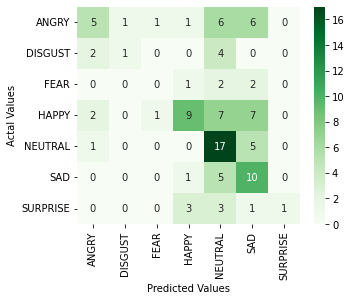

In [83]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap ='Greens')
plt.title('')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [59]:
report = metrics.classification_report(final_groundtruth_emotions,final_predicted_CNN, output_dict=True)

In [64]:
print(metrics.classification_report(final_groundtruth_emotions,final_predicted_CNN))

              precision    recall  f1-score   support

       Angry       0.50      0.25      0.33        20
     Disgust       0.50      0.14      0.22         7
        Fear       0.00      0.00      0.00         5
       Happy       0.60      0.35      0.44        26
     Neutral       0.39      0.74      0.51        23
         Sad       0.32      0.62      0.43        16
    Surprise       1.00      0.12      0.22         8

    accuracy                           0.41       105
   macro avg       0.47      0.32      0.31       105
weighted avg       0.49      0.41      0.38       105



In [60]:
df = pd.DataFrame(report).transpose()

In [61]:
## saving the predictions 

df.to_csv('CNN_fer_ClassReport.csv')

## SVM Results 

### This is to evaluate the results of SVM trained on FER-2013

In [68]:
svm_results_data = pd.read_csv('hog_svm_out.csv')

In [69]:
svm_results_data.head()

,emotion,Video_name
0,sad,Video 0.mp4
1,fear,Video 1.mp4
2,neutral,Video 2.mp4
3,angry,Video 3.mp4
4,sad,Video 4.mp4


In [70]:
predicted_emotions  = svm_results_data['emotion']
predicted_emotions

0           sad
1          fear
2       neutral
3         angry
4           sad
         ...   
100       happy
101    surprise
102         sad
103     neutral
104       happy
Name: emotion, Length: 105, dtype: object

In [71]:
predicted_emotions = svm_results_data['emotion']
predicted_emotions

0           sad
1          fear
2       neutral
3         angry
4           sad
         ...   
100       happy
101    surprise
102         sad
103     neutral
104       happy
Name: emotion, Length: 105, dtype: object

In [72]:
ground_truth_emotions = []
for i in final_groundtruth_emotions:
    ground_truth_emotions.append(i.lower())

In [73]:
ground_truth_emotions

['happy',
 'disgust',
 'angry',
 'disgust',
 'disgust',
 'sad',
 'neutral',
 'angry',
 'angry',
 'angry',
 'happy',
 'neutral',
 'happy',
 'sad',
 'neutral',
 'angry',
 'angry',
 'happy',
 'happy',
 'angry',
 'neutral',
 'angry',
 'sad',
 'sad',
 'happy',
 'sad',
 'sad',
 'fear',
 'fear',
 'sad',
 'surprise',
 'angry',
 'angry',
 'neutral',
 'sad',
 'neutral',
 'surprise',
 'happy',
 'happy',
 'neutral',
 'surprise',
 'angry',
 'surprise',
 'disgust',
 'neutral',
 'neutral',
 'neutral',
 'angry',
 'fear',
 'angry',
 'angry',
 'fear',
 'neutral',
 'angry',
 'neutral',
 'happy',
 'happy',
 'neutral',
 'disgust',
 'disgust',
 'disgust',
 'happy',
 'angry',
 'neutral',
 'sad',
 'sad',
 'happy',
 'angry',
 'happy',
 'sad',
 'angry',
 'angry',
 'happy',
 'happy',
 'sad',
 'happy',
 'sad',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happy',
 'happy',
 'happy',
 'happy',
 'neutral',
 'surprise',
 'sad',
 'surprise',
 'surprise',
 'surprise',
 'sad',
 'happy',
 'happy',
 'angry',
 'happy'

In [74]:
print(metrics.classification_report(ground_truth_emotions,predicted_emotions))

              precision    recall  f1-score   support

       angry       0.57      0.20      0.30        20
     disgust       0.00      0.00      0.00         7
        fear       0.00      0.00      0.00         5
       happy       0.86      0.46      0.60        26
     neutral       0.44      0.61      0.51        23
         sad       0.25      0.62      0.36        16
    surprise       0.50      0.25      0.33         8

    accuracy                           0.40       105
   macro avg       0.37      0.31      0.30       105
weighted avg       0.49      0.40      0.40       105



C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [87]:
report = metrics.classification_report(ground_truth_emotions,predicted_emotions, output_dict=True)

C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Khizer Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [88]:
df  = pd.DataFrame(report).transpose()

In [90]:
df.to_csv('SVM_FER_CLF.csv')

In [75]:
cm_svm = metrics.confusion_matrix(ground_truth_emotions,predicted_emotions)
cm_svm_df = pd.DataFrame(cm_svm,
                     index = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'], 
                     columns = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'])

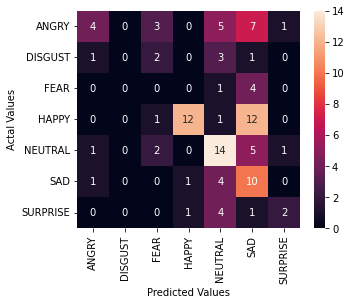

In [84]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm_df, annot=True)
plt.title('')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()